In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

- Выбор датасетов:

In [2]:
df = pd.read_csv("../res/california_housing_train.csv")

- Получите и визуализируйте статистику по датасету (включая количество, среднее значение, стандартное отклонение, минимум, максимум и различные квантили).

Проверим, загрузилось ли и посмотрим, какие именно данные у нас есть

In [3]:
df.sample(n=5, random_state=42)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
10941    -120.87     37.77                 9.0       4838.0           920.0   
5250     -118.14     34.11                52.0       2742.0           422.0   
10292    -120.05     36.98                16.0       3705.0           739.0   
2266     -117.42     34.02                 9.0       5455.0           882.0   
6398     -118.26     33.97                52.0       1331.0           346.0   

       population  households  median_income  median_house_value  
10941      2460.0       923.0         3.5959            142700.0  
5250       1153.0       414.0         8.1124            500001.0  
10292      2463.0       697.0         2.5288             61800.0  
2266       3015.0       858.0         4.2321            162800.0  
6398       1144.0       362.0         1.5326             90600.0

In [4]:
print(df.columns)
print()
df.info() # Что по распознанным типам?
df.describe() # Статистики по данным

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           17000 non-null  float64
 1   latitude            17000 non-null  float64
 2   housing_median_age  17000 non-null  float64
 3   total_rooms         17000 non-null  float64
 4   total_bedrooms      17000 non-null  float64
 5   population          17000 non-null  float64
 6   households          17000 non-null  float64
 7   median_income       17000 non-null  float64
 8   median_house_value  17000 non-null  float64
dtypes: float64(9)
memory usage: 1.2 MB


longitude      latitude  housing_median_age   total_rooms  \
count  17000.000000  17000.000000        17000.000000  17000.000000   
mean    -119.562108     35.625225           28.589353   2643.664412   
std        2.005166      2.137340           12.586937   2179.947071   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.790000     33.930000           18.000000   1462.000000   
50%     -118.490000     34.250000           29.000000   2127.000000   
75%     -118.000000     37.720000           37.000000   3151.250000   
max     -114.310000     41.950000           52.000000  37937.000000   

       total_bedrooms    population    households  median_income  \
count    17000.000000  17000.000000  17000.000000   17000.000000   
mean       539.410824   1429.573941    501.221941       3.883578   
std        421.499452   1147.852959    384.520841       1.908157   
min          1.000000      3.000000      1.000000       0.499900   
25%        297.000000    790.000000    282.000000       2.566375   
50%        434.000000   1167.000000    409.000000       3.544600   
75%        648.250000   1721.000000    605.250000       4.767000   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        17000.000000  
mean        207300.912353  
std         115983.764387  
min          14999.000000  
25%         119400.000000  
50%         180400.000000  
75%         265000.000000  
max         500001.000000

Как видим, чинить распознанные типы не нужно

- Проведите предварительную обработку данных, включая обработку отсутствующих
  значений, кодирование категориальных признаков и нормировка.

In [5]:
df.isna().values.any() # есть пропуски?

False

Типы распознаны, NaN'ов нет, все данные численные. Так что дополнительная обработка не нужна.

У нас же есть широта и долгота 🤔... Давайте изобразим

<Axes: >

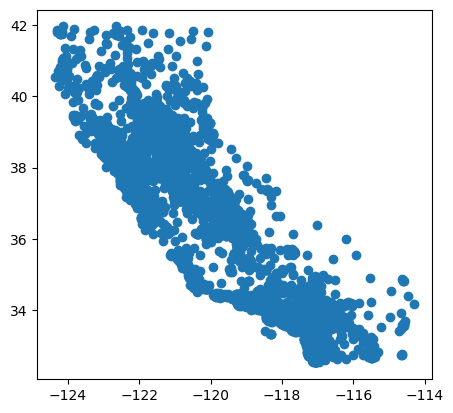

In [6]:
import geopandas as gpd
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude']))
gdf.plot()

И правда похоже на Калифорнию 🤩

- Разделите данные на обучающий и тестовый наборы данных.

In [7]:
from pandas import DataFrame
def my_train_test_split( 
    *dataframes: DataFrame, #TODO: fix type hints
    test_size: float=None, 
    random_state: float=None
) -> list[DataFrame]:
    if test_size is None:
        return dataframes
    if test_size < 0 or 1 < test_size:
        raise ValueError("`train_size` must be a partial in range (0, 1)")
    
    res = [None for _ in range(len(dataframes) * 2)]
    for i, df in enumerate(dataframes):
        test_data_size = int(len(df) * test_size)
        indices = pd.Series(np.arange(0, len(df), 1))
        test_indices = indices.sample(test_data_size, random_state=random_state)
        test_data = df.iloc[test_indices]
        train_data = df.iloc[indices.drop(test_indices)]
        res[i * 2], res[i * 2 + 1] = train_data, test_data
    return res

In [8]:
df_train, df_test = my_train_test_split(df, test_size=0.3, random_state=42)

- Реализуйте линейную регрессию с использованием метода наименьших квадратов без
использования сторонних библиотек, кроме `NumPy` и `Pandas`. Использовать
минимизацию суммы квадратов разностей между фактическими и предсказанными
значениями для нахождения оптимальных коэффициентов.

### Линейная регрессия

Линейные методы предполагают, что между признаками объекта и целевой переменной существует линейная зависимость, то есть
$$
    y = w_1 x_1 + w_2 x_2 + ... + w_k x_k + b,
$$
где $у$ — целевая переменная, $x_i$ — признак объекта $х$, $w_i$ — вес $i$-го признака, $b$ — bias (смещение, свободный член)

Часто предполагают, что объект $х$ содержит в себе фиктивный признак равный 1 для представления свободного члена $b$. В этом случае формула принимает простой вид:
$$
    y = \langle w, x \rangle,
$$
где $\langle \cdot, \cdot \rangle$ — скалярное произведение векторов $w, x \in \mathbb{R}^n$.

В матричной форме, в случае, когда у нас есть $m$ объектов формулу можно переписать следующим образом:
$$
    Y = Xw, 
$$
где $Y$ — столбец размера $n$, $X$ — матрица признаков размера $n \times k$, $w$ — вектор весов размера $k$.

**Лосс:**
$$
\begin{aligned}
L(y_{pred}, Y) &= \frac{1}{n}||y_{pred} - Y||^2_2 =\\
&= \frac{1}{n}||Xw - Y||^2_2 = \frac{1}{n}\sum_{i=1}^{n}\left(\sum_{j=1}^{m} x_{ij}w_j - y_i\right)^2 =: L(w)
\end{aligned}
$$

**Аналитическое решение.**

Минимизация ошибки по методу наименьших квадратов дает решение: 
$$
    w = (X^TX)^{-1}X^TY 
$$

Реализуем класс линейной регрессии с помощью этой формулы.

In [9]:
from typing import Self
class MyLinearRegression(object):
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept

    def fit(self, X: pd.DataFrame, y: pd.DataFrame) -> Self:
        n, k = X.shape
        X_train = X if not self.fit_intercept else np.hstack((X, np.ones((n, 1))))

        self.w = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y.values

        return self
    
    def predict(self, X: pd.DataFrame) -> pd.DataFrame:
        n, k = X.shape
        
        X_train = X if not self.fit_intercept else np.hstack((X, np.ones((n,1))))
        return pd.DataFrame(X_train @ self.w)

Добавим в модель регуляризацию признаков.
В ridge мы штрафуем модель также на сумму квадратов всех ее весов, таким образом:

**Лосс:** $L(w) = ||Xw - Y||^2_2 + \lambda||w||^2_2$, где $\lambda$ - гиперпараметр, отвечающий за степень регуляризации.

Аналитическое решение

Из курса статистики известно, что
$$
    L(w) = ||Xw - Y||^2_2 + ||\Gamma w||^2_2 
$$

минимизируется при

$$
    w = (X^TX + \Gamma^T \Gamma)^{-1}X^TY. 
$$

В нашем случае $\Gamma^T\Gamma = \lambda I$, если нет свободного члена, иначе:
$\Gamma^T\Gamma =
\left(\begin{matrix}
\lambda I & 0 \\
        0 & 0
\end{matrix}\right)$.

In [10]:
from typing import Self
class MyRidgeRegression(MyLinearRegression):
    def __init__(self, alpha: float=1.0, **kwargs) -> None:
        super().__init__(**kwargs)
        self.alpha = alpha

    def fit(self, X: pd.DataFrame, y: pd.DataFrame) -> Self:
        n, m = X.shape

        X_train = X if not self.fit_intercept else np.hstack((X, np.ones((n, 1))))

        lambdaI = self.alpha * np.eye(X_train.shape[1])
        if self.fit_intercept:
            lambdaI[-1, -1] = 0

        self.w = np.linalg.inv(X_train.T @ X_train + lambdaI) @ X_train.T @ y

        return self

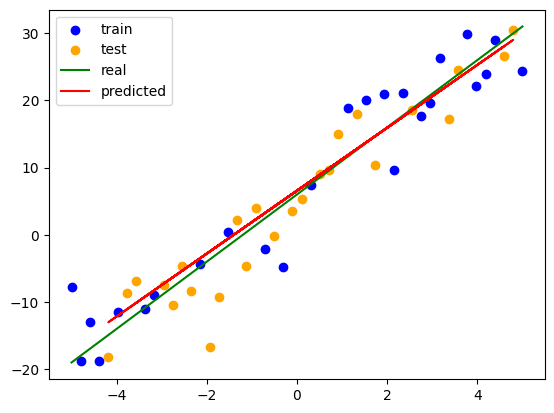

In [11]:
linear_expression = lambda x: 5 * x + 6
objects_num = 50
x_data = np.linspace(-5, 5, objects_num)
y_data = linear_expression(x_data) + np.random.randn(objects_num) * 5

(X_train, X_test, 
 y_train, y_test) = my_train_test_split(
     pd.DataFrame(x_data), 
     pd.DataFrame(y_data), 
     test_size=0.5, random_state=4
)

# y_pred = MyLinearRegression().fit(X_train, y_train).predict(X_test)
y_pred = MyRidgeRegression().fit(X_train, y_train).predict(X_test)

plt.scatter(X_train, y_train, label='train', c='b')
plt.scatter(X_test, y_test, label='test', c='orange')
plt.plot(x_data, linear_expression(x_data), label='real', c='g')
plt.plot(X_test, y_pred, label='predicted', c='r')
plt.legend()
plt.show()

- Постройте **три модели** с различными наборами признаков.



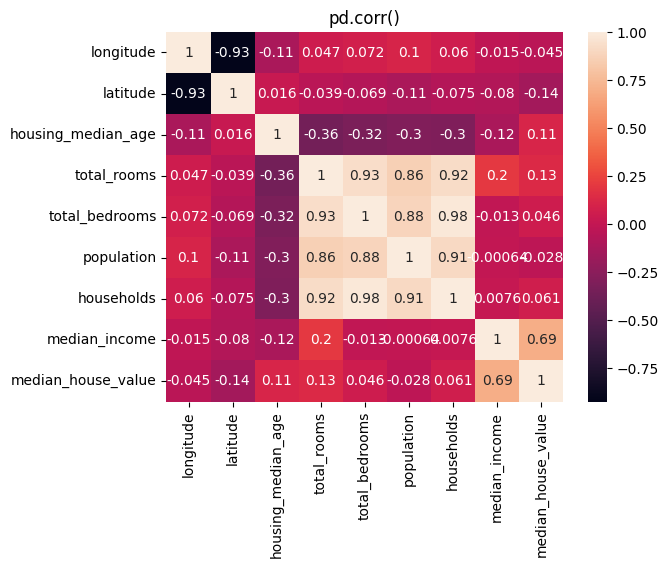

interval columns not set, guessing: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']


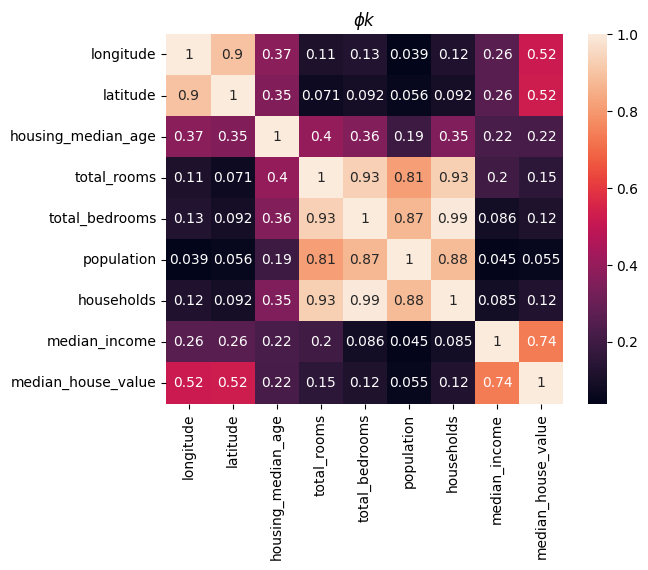

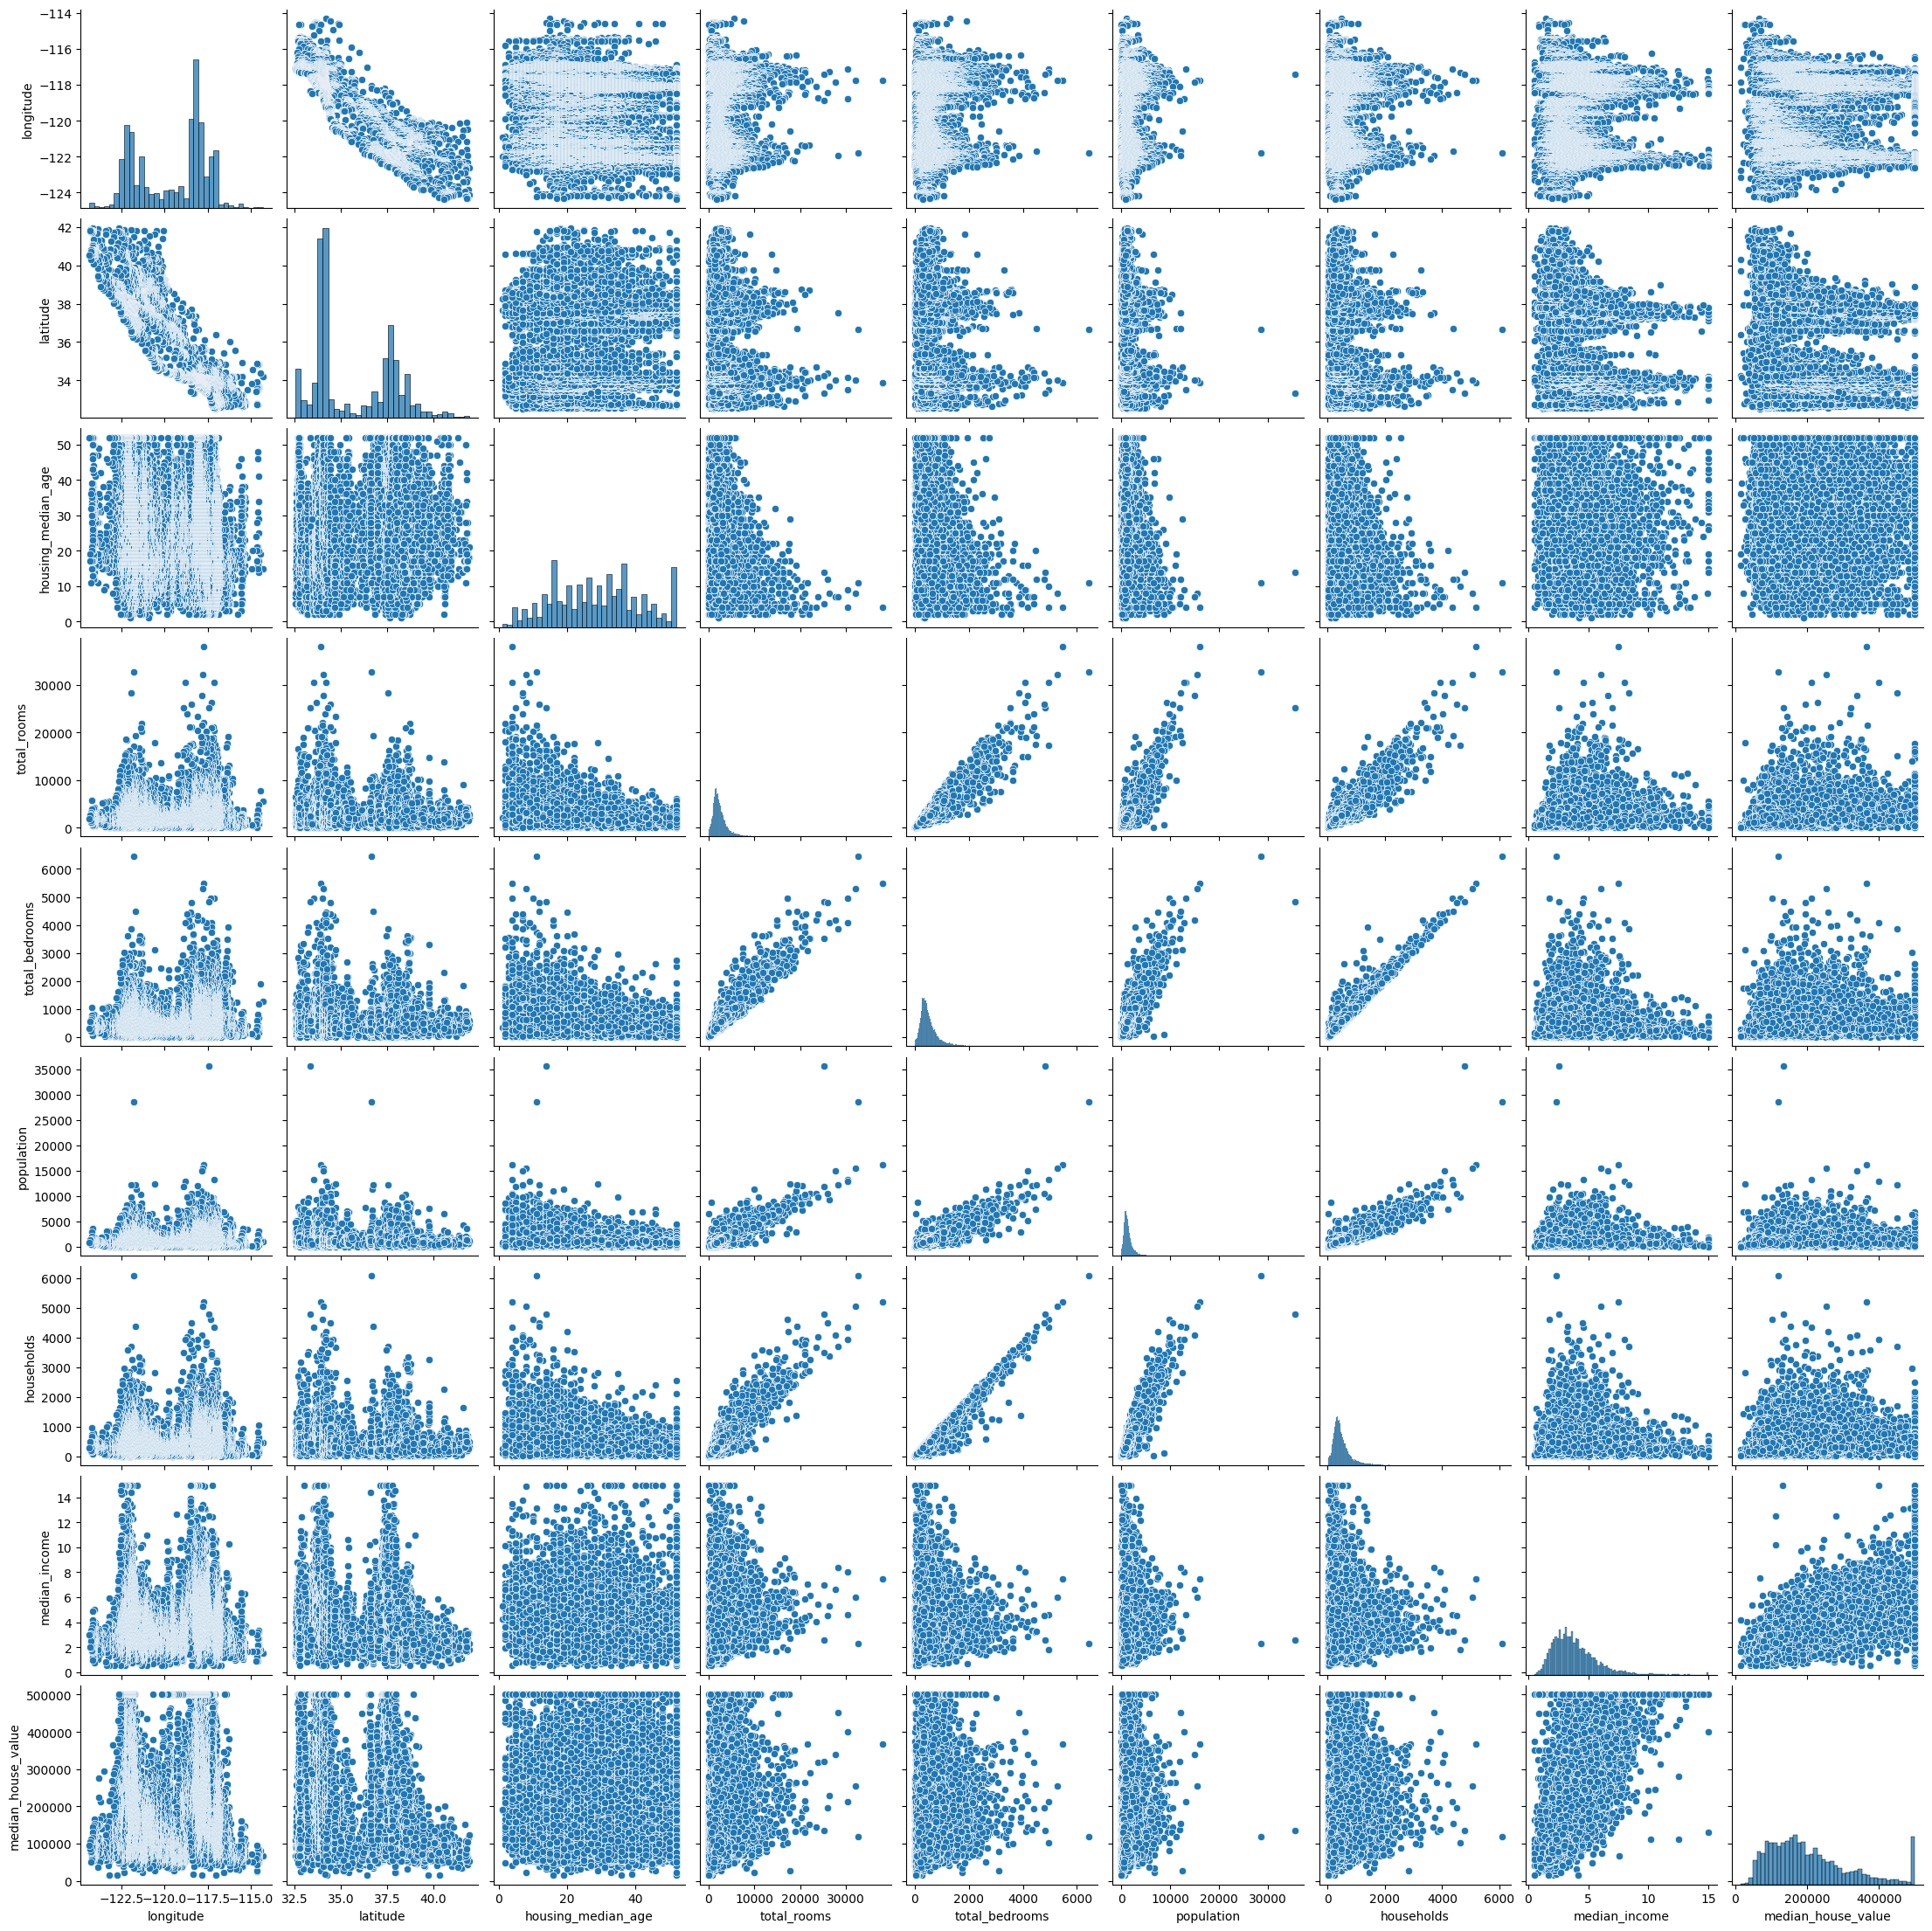

In [12]:
sns.heatmap(df.corr(), annot=True); plt.title("pd.corr()"); plt.show()

import phik
sns.heatmap(df.phik_matrix(), annot=True); plt.title("$\phi k$"); plt.show()

sns.pairplot(df); plt.show()

Наиболее интересно коррелирующие столбцы:
```python
{
  'longitude': 'housing_median_age',
  'latitude': 'median_house_value',
  'housing_median_age': 'total_rooms',
  'total_bedrooms': 'households', # 1
  'total_bedrooms': 'population',
  'total_rooms': 'population', # 2
  'population': 'households', # 3
}
```
(С особенно хорошей корреляцией отмечены комментариями)

- Для каждой модели проведите оценку производительности, используя метрику
  коэффициент детерминации, чтобы измерить, насколько хорошо модель
  соответствует данным.



Опишем просные транформеры данных (Спойлер: они почти никак не влияют).

In [13]:
from typing import Self
class MyStandardScaler(object):
    def __init__(self, with_mean=True, with_std=True) -> None:
        self.with_mean = with_mean
        self.with_std = with_std

    def fit(self, X: pd.DataFrame, y: pd.DataFrame=None) -> Self:
        self.means = X.mean() if self.with_mean else None
        self.stds = X.std(ddof=1) if self.with_std else None
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        transformed_X = X
        if self.with_mean:
            transformed_X = transformed_X - self.means
        if self.with_std:
            transformed_X = transformed_X / self.stds
        return transformed_X


class MyMinMaxScaler(object):
    def fit(self, X: pd.DataFrame, y: pd.DataFrame=None) -> Self:
        self.width = X.max() - X.min()
        self.avg = X.min() + self.width / 2
        return self
    
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        return (X - self.avg) / self.width


Для удобства визуализации зависимости используем такую функцию.

In [14]:
def analyse(x: pd.DataFrame, y: pd.DataFrame, rs: float=42) -> pd.DataFrame:
    """ Utility function for quick analytics drawing. """

    from sklearn.metrics import r2_score
    from time import monotonic

    (x_data_train, x_data_test, 
     y_data_train, y_data_test) = my_train_test_split(x, y, test_size=0.3, random_state=rs)

    start_time = monotonic()

    # y_pred = MyLinearRegression()
    y_pred = MyRidgeRegression()\
        .fit(X=x_data_train.values[:,np.newaxis], y=y_data_train)\
        .predict(x_data_test.values[:,np.newaxis])

    end_time = monotonic()

    plt.title(f'{x.name}↦{y.name}\n(R2={r2_score(y_data_test, y_pred):.4f}) [{end_time-start_time:.3f}s]')
    plt.scatter(x_data_train, y_data_train, label='train', c='b')
    plt.scatter(x_data_test, y_data_test, label='test', c='g')
    plt.plot(x_data_test, y_pred, label='pred', c='r')
    plt.legend()


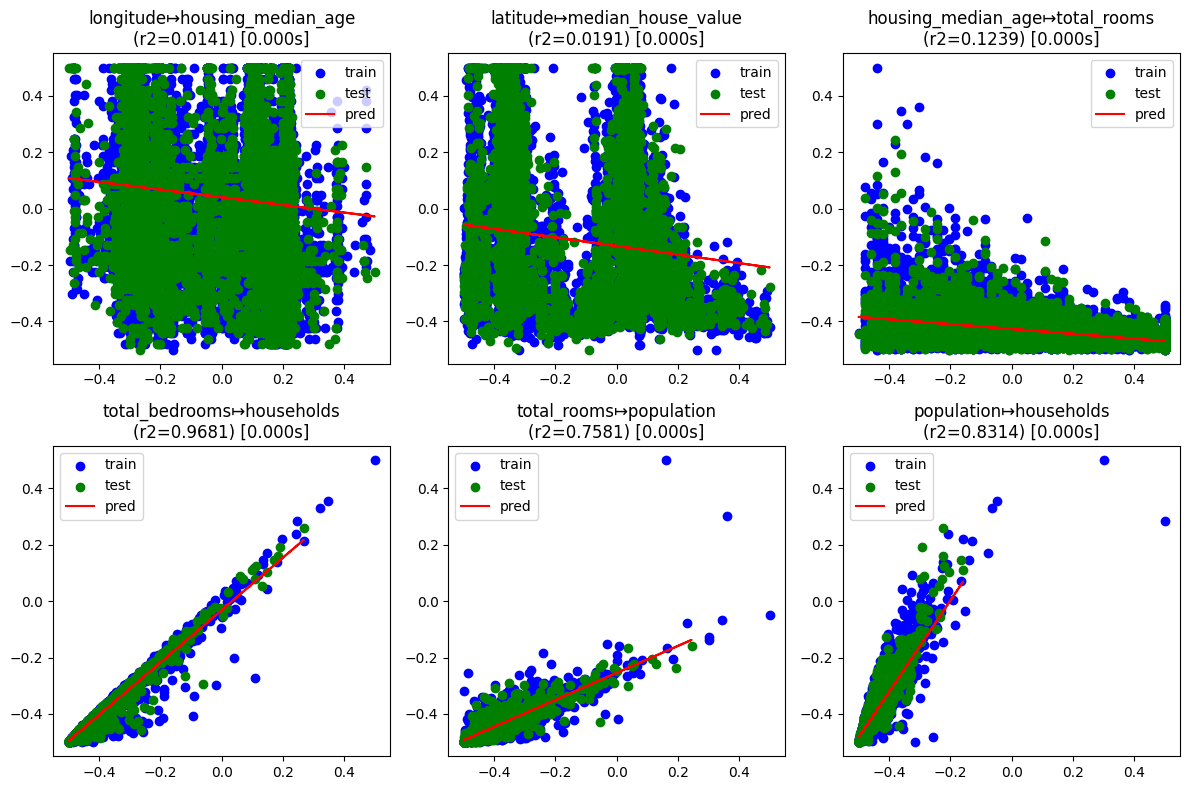

In [15]:
# df_tf = MyStandardScaler().fit(df).transform(df) 
df_tf = MyMinMaxScaler().fit(df).transform(df) 
interesting_correlations = {
  'longitude': 'housing_median_age',
  'latitude': 'median_house_value',
  'housing_median_age': 'total_rooms',
  'total_bedrooms': 'households',
  # 'total_bedrooms': 'population',
  'total_rooms': 'population',
  'population': 'households',
}

plt.figure(figsize=(12,8))
for i, (x, y) in enumerate(interesting_correlations.items()):
    plt.subplot(2, 3, i+1)
    analyse(df_tf[x], df_tf[y])
plt.tight_layout(); plt.show()

Попробуем метод главных компонент, мб получится лучше результат получить. Мой $R^2$ почему-то работает отлично от sklearn.metrics варианта, поэтому я использую их.

In [16]:
def PCA(X: pd.DataFrame, n_components: int=1) -> pd.DataFrame:
    assert n_components >= 1, 'n_components must be ceil non negative'

    X_meaned = X - np.mean(X , axis = 0) 
    X_cov = np.cov(X_meaned , rowvar = False)
    eigen_values, eigen_vectors = np.linalg.eigh(X_cov)

    sorted_index = np.argsort(eigen_values)[::-1]
    # sorted_eigen_value = eigen_values[sorted_index]
    sorted_eigen_vectors = eigen_vectors[:, sorted_index]
    eigen_vector_subset = sorted_eigen_vectors[:, :n_components]
    X_reduced = (eigen_vector_subset.T @ X_meaned.T).T
     
    return X_reduced

def my_r2_score(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
    ss_reg = ((y_pred - y_true.mean()) ** 2).sum(axis=0)
    ss_res = ((y_true - y_pred) ** 2).sum(axis=0)
    ss_tot = ((y_true - y_true.mean()) ** 2).sum(axis=0) # =: ss_res + ss_reg
    # r2 = (1 - (ss_res / ss_tot))[0] # работает не как в sklearn
    r2 = (ss_reg / ss_tot)[0] # похоже работает как в sklearn
    
    return r2


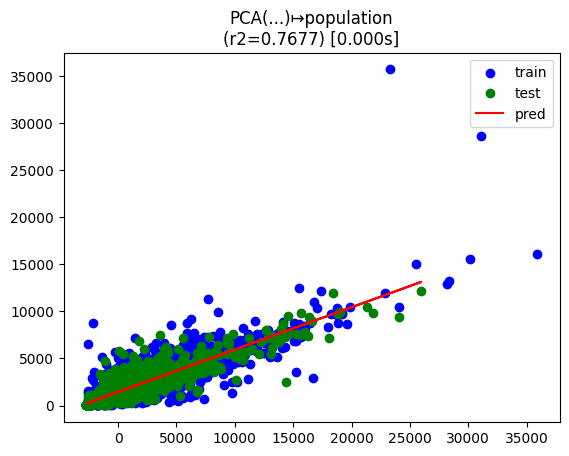

In [17]:
inspecting_cols = [
    'longitude',
    'latitude',
    'housing_median_age' ,
    'total_rooms',
    'total_bedrooms' ,
    # 'population' ,
    'households',
    # 'median_income',
    # 'median_house_value',
]
x_data = PCA(df[inspecting_cols]).iloc[:,0]
x_data.name = 'PCA(...)'
y_data = df['population']
analyse(x_data, y_data)

- Сравните результаты трех моделей и сделайте выводы о том, какие признаки
  работают лучше всего для каждой модели.



R2 = 0.884417492901195


attr       weight
0           longitude  -140.184431
1            latitude  -216.296781
2  housing_median_age     5.328906
3         total_rooms   402.869755
4      total_bedrooms  -593.981837
5          households  1264.709300
6       median_income     6.904976
7  median_house_value  -178.991748

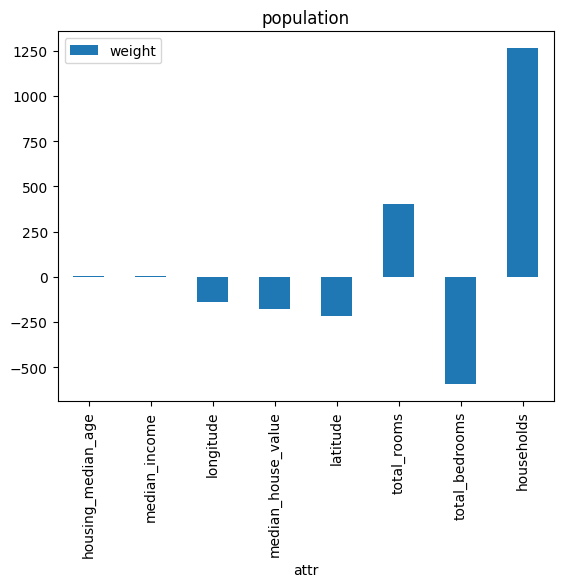

In [84]:
df_scaled = MyStandardScaler().fit(df.drop('population', axis=1)).transform(df.drop('population', axis=1))
(X_train, X_test, 
 y_train, y_test) = my_train_test_split(
     df_scaled, 
     df['population'], 
     test_size=0.2, random_state=4
)
model = MyLinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import r2_score
print(f'R2 = {r2_score(y_test, y_pred)}')
bar = pd.DataFrame(zip(df.drop('population', axis=1).columns.values, model.w), columns=('attr', 'weight'))
bar.sort_values(by='weight', axis=0, key=np.abs).plot.bar(x='attr', title='population')
bar

Самодельные модели Линейной регрессии оказались достаточно быстрыми (время их работы указано на графиках). Сильнокоррелирующие данные дают ожидаемо хороший результат при построении модели. `households` лучше всего описывается линейной зависимостью от `total_bedrooms`. Ну и `population` преемлемо линейно зависит от `households`.

- Бонусное задание
    - Ввести синтетический признак при построении модели


In [19]:

df_ext = pd.DataFrame()
df_ext['kek'] = df_scaled['total_bedrooms'] / df_scaled['median_income']
# df_ext['lol'] = (df['latitude'] / df['longitude'] ** df['housing_median_age']) 
# df_ext['idk'] = df['households'] * df['housing_median_age']
# df_ext['etc'] = np.exp(df_ext['lol'])
df_ext

kek
0       858.998393
1      1044.505495
2       105.397056
3       105.586365
4       169.350649
...            ...
16995   167.154554
16996   209.698558
16997   175.172368
16998   278.830126
16999    99.512389

[17000 rows x 1 columns]

In [20]:
df_new = pd.concat((df_scaled, df_ext), axis=1)
df_new.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  17000.000000  17000.000000        17000.000000  17000.000000   
mean    -119.562108     35.625225           28.589353   2643.664412   
std        2.005166      2.137340           12.586937   2179.947071   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.790000     33.930000           18.000000   1462.000000   
50%     -118.490000     34.250000           29.000000   2127.000000   
75%     -118.000000     37.720000           37.000000   3151.250000   
max     -114.310000     41.950000           52.000000  37937.000000   

       total_bedrooms    population    households  median_income  \
count    17000.000000  17000.000000  17000.000000   17000.000000   
mean       539.410824   1429.573941    501.221941       3.883578   
std        421.499452   1147.852959    384.520841       1.908157   
min          1.000000      3.000000      1.000000       0.499900   
25%        297.000000    790.000000    282.000000       2.566375   
50%        434.000000   1167.000000    409.000000       3.544600   
75%        648.250000   1721.000000    605.250000       4.767000   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value           kek  
count        17000.000000  17000.000000  
mean        207300.912353    170.053466  
std         115983.764387    156.901700  
min          14999.000000      0.066666  
25%         119400.000000     74.282861  
50%         180400.000000    126.403073  
75%         265000.000000    215.089843  
max         500001.000000   2869.372694

0.870784287455924


attr     weight
0  housing_median_age   1.917701
1         total_rooms   0.089595
2          households   2.367860
3       median_income  31.261550
4  median_house_value  -0.001356
5                 kek  -0.090135

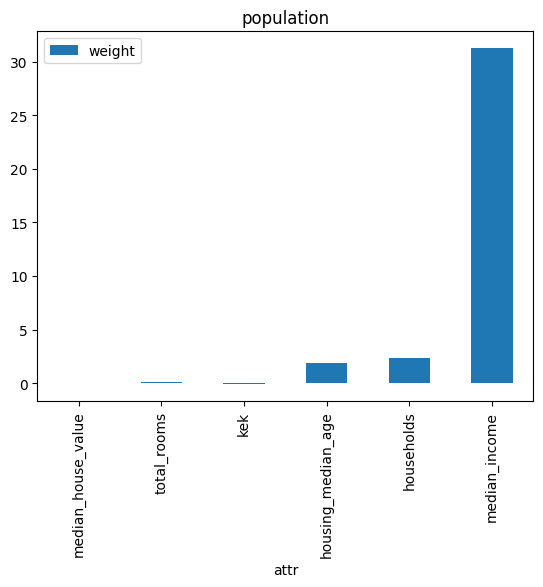

In [82]:
inspecting_cols_new = [
    # 'longitude',
    # 'latitude',
    'housing_median_age' ,
    'total_rooms',
    # 'total_bedrooms',
    # 'population',
    'households',
    'median_income',
    'median_house_value',
    'kek', 
    # 'lol', 
    # 'idk', 
    # 'etc'
]
(X_train, X_test, 
 y_train, y_test) = my_train_test_split(
     df_new[inspecting_cols_new], 
     df_new['population'], 
     test_size=0.4, random_state=42
)
model = MyRidgeRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import r2_score
print(f'R2 = {r2_score(y_test, y_pred)}')
bar = pd.DataFrame(zip(inspecting_cols_new, model.w), columns=('attr', 'weight'))
bar.sort_values(by='weight', axis=0, key=np.abs).plot.bar(x='attr', title='population')
bar

Результаты не плохие, но зависят от составления выборки. Лучше чем предсказания по одному признаку (серия графиков выше) предсказания не получаются.  

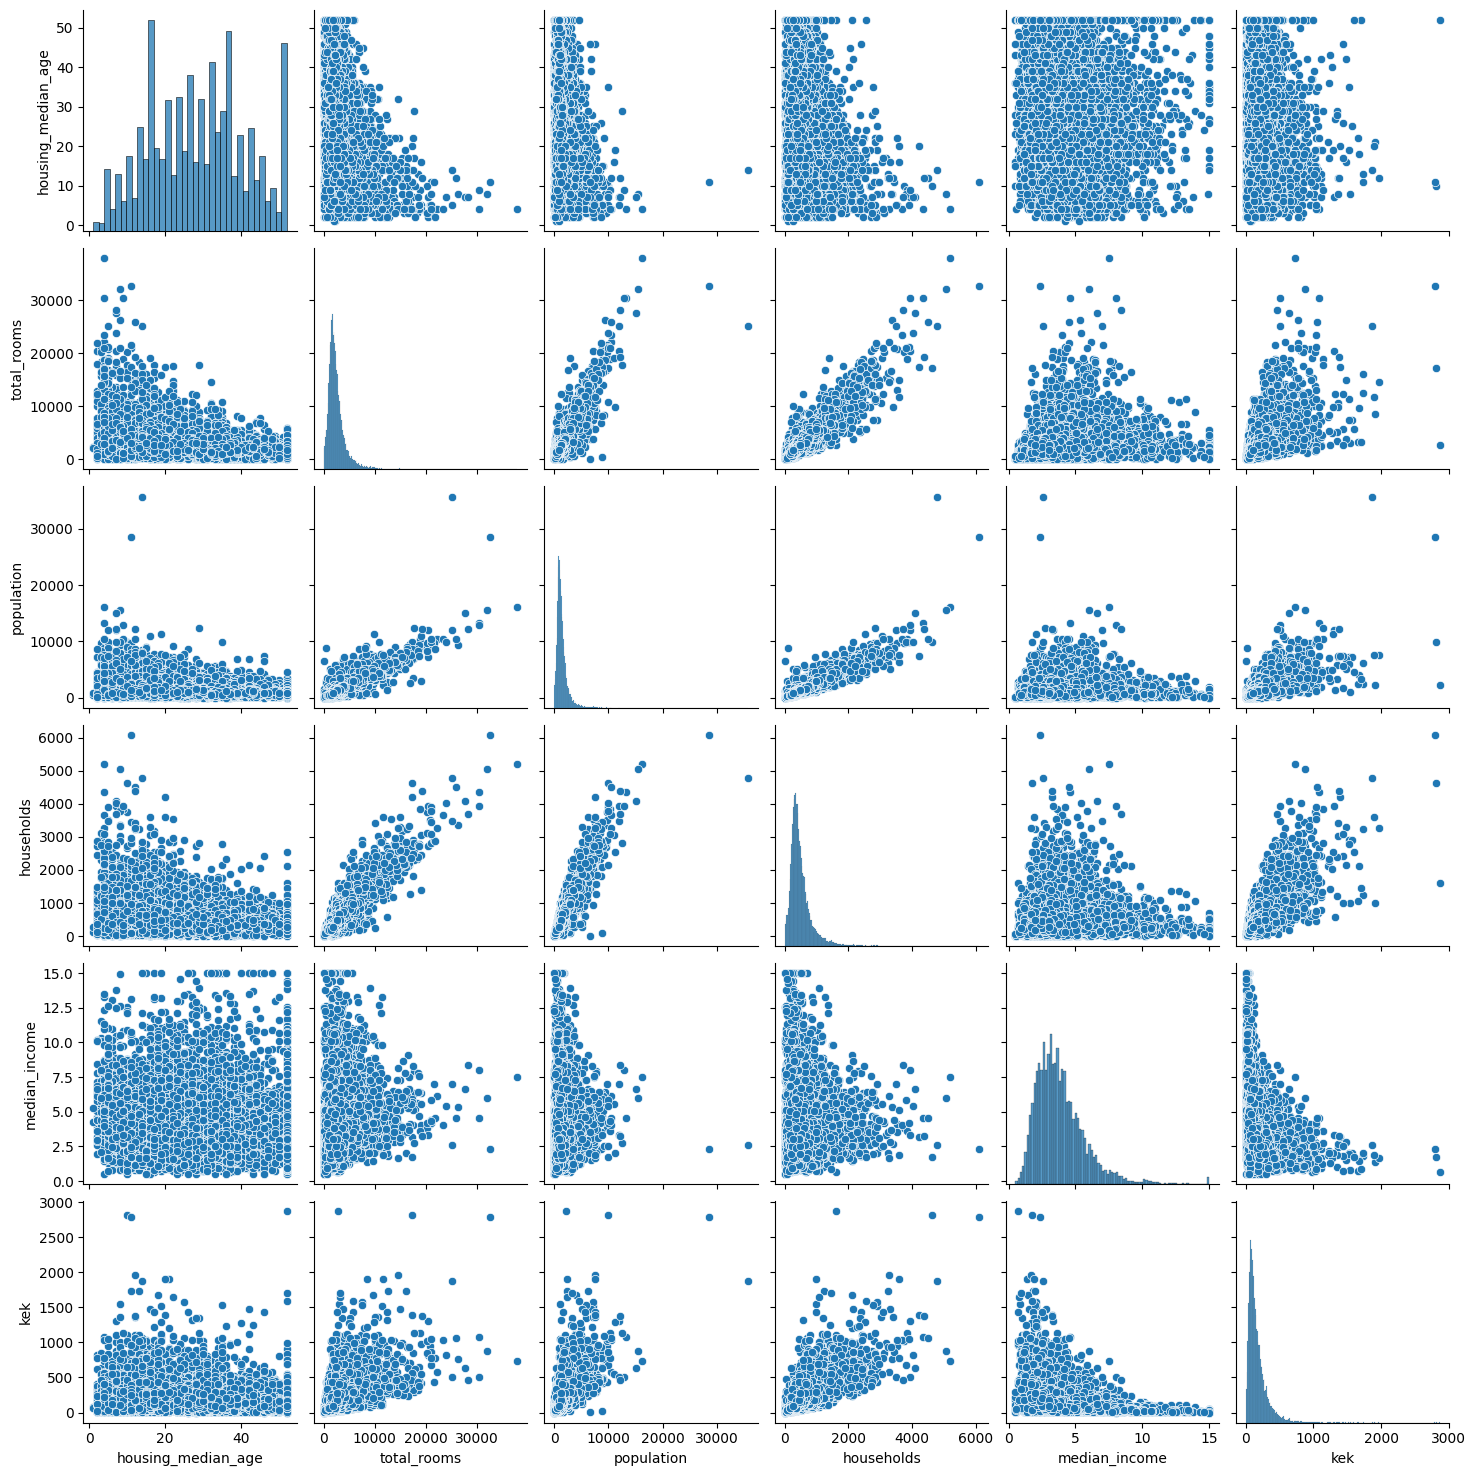

In [83]:
sns.pairplot(df_new[[
    # 'longitude',
    # 'latitude',
    'housing_median_age' ,
    'total_rooms',
    # 'total_bedrooms',
    'population',
    'households',
    'median_income',
    # 'median_house_value',
    'kek', 
    # 'lol', 
    # 'idk', 
    # 'etc'
]])

Не удается получить вменяемый результат при комбинированиии признаков. Не хочется настолько усложнить данные, чтобы в [хаосе обнаружилась линейная зависимость](https://economicsfromthetopdown.com/2022/04/08/the-dunning-kruger-effect-is-autocorrelation/).

## Вывод

Построили модели линейной регрессии, в том числе с регуляризацией. Исследовали датасет на возможность предсказания данных и получили ожидаемые результаты: линейная регрессия применима там, где уже видна линейная зависимость. Никакие махинации с комбинированием признаков (созданием синтетических) не дают положительного результата. При этом опасно случайно повестись на появление, казалось бы интересной, зависимости на графике синтетического признака и потом в еще одном синтетическом признаке использовать предыдущий: в результате получим просто дубликат изначального признака.